In [2]:
import io_tools

# 分析与处理 for evaluate

In [ ]:
import os 
all_files = os.listdir('/mnt/new_pfs/liming_team/auroraX/zxl/project/X1/rollout_verify/mxd0520')
all_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
all_files

In [ ]:
import json
all_res = []
for file in all_files:
    with open(os.path.join('/mnt/new_pfs/liming_team/auroraX/zxl/project/X1/rollout_verify/mxd0520', file), 'r') as f:
            all_res.extend(json.load(f))

all_res[0], len(all_res)

In [ ]:
cnt = 0
for res in all_res:
    try:
        res['llm_output_processed'] = json.loads(res['llm_output'])
    except:
        cnt += 1
        res['llm_output_processed'] = {
            'final_answer': 'json error',
        }
cnt, len(all_res)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/AuroraX-00/share_v3/wangyuankun/NotoSansSC-VariableFont_wght.ttf'
# font_path = '/mnt/new_pfs/liming_team/auroraX/tianyu/new_pub/AI_tutor/SourceHanSansSC-VF.ttf' 
fm.fontManager.addfont(font_path)
# 设置黑体
custom_font = fm.FontProperties(fname=font_path, weight='bold')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [custom_font.get_name()] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

split_res = [all_res[i:i+32] for i in range(0, len(all_res), 32)]
error_ratio = []
for item in split_res:
    meta_cnt = 0
    for meta in item:
        if meta['llm_output_processed']['final_answer'] == 'json error':
            meta_cnt += 1
    error_ratio.append(meta_cnt/32)

print(len([item for item in error_ratio if item > 0.25]))
# 可视化 error_ratio 的分布
plt.figure(figsize=(8,4))
plt.hist(error_ratio, bins=20, edgecolor='black')
plt.xlabel('error_ratio')
plt.ylabel('分组数量')
plt.title('error_ratio 分布直方图')
plt.show()

# 也可以简单打印一些统计信息
import numpy as np
print(f"error_ratio 平均值: {np.mean(error_ratio):.4f}")
print(f"error_ratio 最大值: {np.max(error_ratio):.4f}")
print(f"error_ratio 最小值: {np.min(error_ratio):.4f}")

In [ ]:
_pre_gen = []
for item in all_res:
    tmp = {
        'answer': item['answer'],
        'final_answer': item['llm_output_processed']['final_answer'],
        'question': item['question'],
        'acc': item['acc'],
    }
    _pre_gen.append(tmp.copy())
len(_pre_gen)

In [ ]:
io_tools.write_jsonl(os.path.join('/mnt/new_pfs/liming_team/auroraX/mxd/a_x1/rollout_verify/res', 'pre_gen_res.jsonl'), _pre_gen)

# 结果验证

In [3]:
verfiy_roll_out = io_tools.read_txt('/mnt/new_pfs/liming_team/auroraX/mxd/a_x1/data/v1_scale/equiv_acc_merged')
verify_baseline = io_tools.read_json('/mnt/new_pfs/liming_team/auroraX/mxd/a_x1/new_0513/data/v1_50_32_xg/equiv_acc.json')
len(verfiy_roll_out), len(verify_baseline)

(500, 50)

In [4]:
verfiy_batch = io_tools.read_txt('/mnt/new_pfs/liming_team/auroraX/mxd/a_x1/rollout_verify/res/equiv_acc_merged')
len(verfiy_batch)

500

In [5]:
ob = []
cnt = 0
for i in range(len(verify_baseline)):
    baseline = float(verify_baseline[i])
    start_idx = i*10
    end_idx = start_idx + 10
    tmp = verfiy_batch[start_idx:end_idx]
    tmp = [float(item) for item in tmp]
    ob_meta = {
        'up': [up_meta for up_meta in tmp if up_meta > baseline],
        'down': [down_meta for down_meta in tmp if down_meta <= baseline],
        # 'acc': item['acc'],
        'rollouts': tmp,
        'baseline': baseline
    }
    if len(ob_meta['up']) > 0:
        cnt += 1
    ob.append(ob_meta.copy())
cnt

40

In [6]:
ob1 = []
cnt = 0
for i in range(len(verify_baseline)):
    baseline = float(verify_baseline[i])
    start_idx = i*10
    end_idx = start_idx + 10
    tmp = verfiy_roll_out[start_idx:end_idx]
    tmp = [float(item) for item in tmp]
    ob_meta = {
        'up': [up_meta for up_meta in tmp if up_meta > baseline],
        'down': [down_meta for down_meta in tmp if down_meta <= baseline],
        # 'acc': item['acc'],
        'rollouts': tmp,
        'baseline': baseline
    }
    if len(ob_meta['up']) > 0:
        cnt += 1
    ob1.append(ob_meta.copy())
cnt

47

In [19]:
import numpy as np

# 假设 ob 已经构建完毕，格式如：
# ob = [
#     {'up': [...], 'down': [...], 'rollouts': [...], 'baseline': ...},
#     ...
# ]  # 共50组

def compute_consistency(ob, alpha=0.5):
    # 1. 数量一致性（纯 up/down 数量差异）
    consistency_scores = [
        abs(len(x['up']) - len(x['down'])) / len(x['rollouts'])
        for x in ob
    ]
    
    # 2. 幅度一致性（所有分数距离baseline的方向和幅度）
    consistency_magnitude = []
    for x in ob:
        baseline = x['baseline']
        rollouts = x['rollouts']
        if np.sum([abs(v - baseline) for v in rollouts]) == 0:
            # 所有值等于baseline，判为完全一致
            consistency_magnitude.append(1.0)
        else:
            cm = abs(sum(rollouts) - len(rollouts) * baseline) / sum(abs(v - baseline) for v in rollouts)
            consistency_magnitude.append(cm)

    # 3. 综合一致性（加权，默认等权）
    final_score = [
        alpha * a + (1 - alpha) * b
        for a, b in zip(consistency_scores, consistency_magnitude)
    ]

    # 4. 汇总统计
    summary = {
        '数量一致性_均值': np.mean(consistency_scores),
        '数量一致性_标准差': np.std(consistency_scores),
        '幅度一致性_均值': np.mean(consistency_magnitude),
        '幅度一致性_标准差': np.std(consistency_magnitude),
        '综合一致性_均值': np.mean(final_score),
        '综合一致性_标准差': np.std(final_score),
    }

    # 5. 详细结果
    detail = {
        '数量一致性': consistency_scores,
        '幅度一致性': consistency_magnitude,
        '综合一致性': final_score
    }

    return summary, detail

# --- 调用 ---
summary, detail = compute_consistency(ob, alpha=0.5)

print('一致性指标汇总：')
for k, v in summary.items():
    print(f'{k}: {v:.4f}')

# 如需详细每组结果
# print(detail['数量一致性'])
# print(detail['幅度一致性'])
# print(detail['综合一致性'])


一致性指标汇总：
数量一致性_均值: 0.6400
数量一致性_标准差: 0.3150
幅度一致性_均值: 0.7122
幅度一致性_标准差: 0.3210
综合一致性_均值: 0.6761
综合一致性_标准差: 0.3023


In [21]:
print(detail['数量一致性'])
print(len([item for item in detail['数量一致性'] if item < 0.6]))

[1.0, 1.0, 1.0, 0.4, 0.6, 1.0, 0.8, 0.0, 0.2, 0.2, 1.0, 0.2, 0.0, 0.4, 1.0, 0.6, 0.4, 0.6, 0.6, 0.2, 0.8, 0.2, 0.4, 0.8, 0.4, 0.8, 0.8, 1.0, 0.4, 1.0, 1.0, 0.2, 0.2, 0.8, 0.6, 1.0, 0.8, 0.4, 0.8, 1.0, 0.6, 1.0, 0.8, 0.2, 1.0, 0.8, 1.0, 0.4, 0.8, 0.8]
18


In [23]:
print(detail['数量一致性'])
print(len([item for item in detail['数量一致性'] if item < 0.6]))

[0.2, 0.4, 0.6, 0.6, 0.8, 1.0, 0.4, 0.2, 0.8, 0.8, 0.8, 0.8, 0.8, 0.4, 0.2, 0.8, 1.0, 0.8, 0.8, 0.2, 0.6, 0.8, 0.6, 0.8, 0.6, 1.0, 0.6, 0.8, 0.2, 1.0, 1.0, 0.8, 0.6, 0.2, 1.0, 1.0, 1.0, 0.2, 0.2, 0.6, 0.0, 0.6, 0.2, 1.0, 1.0, 0.2, 0.8, 0.8, 0.6, 1.0]
14


In [22]:
summary, detail = compute_consistency(ob1, alpha=0.5)

print('一致性指标汇总：')
for k, v in summary.items():
    print(f'{k}: {v:.4f}')

一致性指标汇总：
数量一致性_均值: 0.6440
数量一致性_标准差: 0.2947
幅度一致性_均值: 0.7448
幅度一致性_标准差: 0.2943
综合一致性_均值: 0.6944
综合一致性_标准差: 0.2780


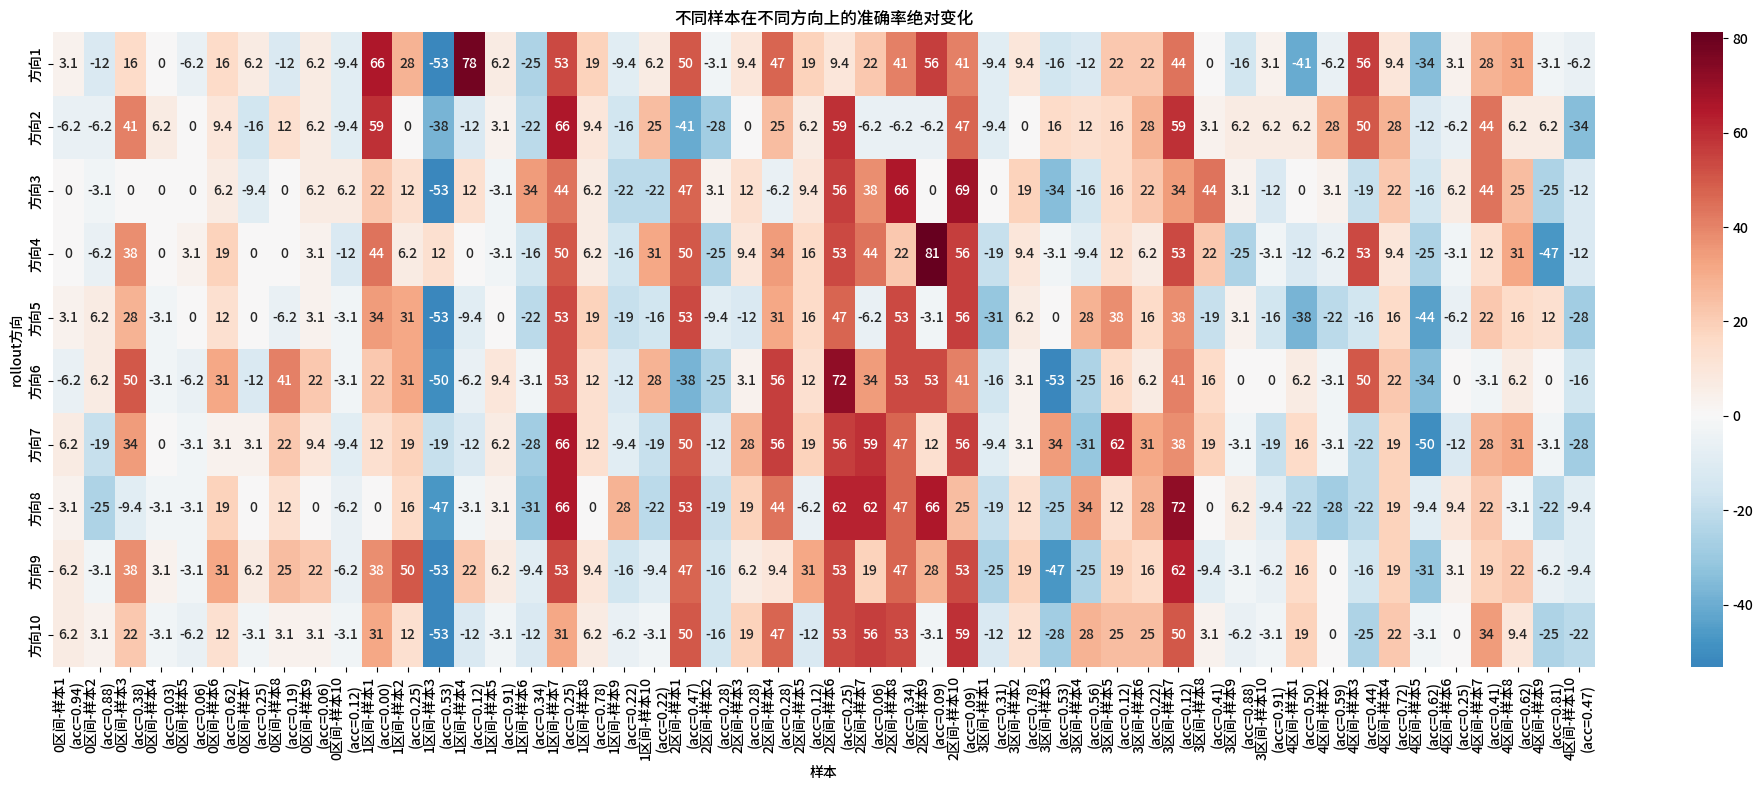

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import font_manager as fm
font_path = '/AuroraX-00/share_v3/wangyuankun/NotoSansSC-VariableFont_wght.ttf'
# font_path = '/mnt/new_pfs/liming_team/auroraX/tianyu/new_pub/AI_tutor/SourceHanSansSC-VF.ttf' 
fm.fontManager.addfont(font_path)
# 设置黑体
custom_font = fm.FontProperties(fname=font_path, weight='bold')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [custom_font.get_name()] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 准备数据结构
sample_count = len(ob)
rollout_count = 10

# 创建热力图数据
heatmap_data = np.zeros((rollout_count, sample_count))

for sample_idx, sample in enumerate(ob):
    original_acc = sample['baseline']
    for rollout_idx, rollout_acc in enumerate(sample['rollouts']):
        # 计算绝对差值
        absolute_diff = rollout_acc - original_acc
        absolute_diff *= 100
        heatmap_data[rollout_idx, sample_idx] = absolute_diff

# 设置样本标签
sample_labels = [f"{i//10}区间-样本{i%10+1}\n(acc={ob[i]['baseline']:.2f})" for i in range(sample_count)]

# 创建热力图
plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data, cmap="RdBu_r", center=0, 
                 xticklabels=sample_labels, 
                 yticklabels=[f"方向{i+1}" for i in range(rollout_count)],
                 annot=True, fmt=".2g")

plt.title("不同样本在不同方向上的准确率绝对变化")
plt.xlabel("样本")
plt.ylabel("rollout方向")
plt.tight_layout()
plt.show()